In [1]:
from pydent import AqSession #pydent is the Aquarium module for python, installable using pip
import os
import datetime
from PIL import Image, ExifTags
import cv2
import numpy as np
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import statistics

In [15]:
username = "maddyscott"
password = "duckweedrox"
plan_id = 41661
cwd = os.getcwd()
dir_path_original= "%s/Images_Plan_%d" % (cwd, plan_id)
dir_path_resized= "%s/Images_%d_CROPPED" % (cwd, plan_id)
dir_path_green= "%s/Images_%d_JUSTGREEN" % (cwd, plan_id)
dir_path_clusters = "%s/Images_%d_CLUSTERS" % (cwd, plan_id)
REDUCTION = 10
PETRI_DIAM = 95 #in mm, the diameter of the TOP lid of the petri dish

In [65]:
#only for this code, determines the nacl conc from filename
def nacl_conc_from_name(name):
    n = name.split("_")
    if len(n) == 3:
        return int(n[2])
    return 0

#takes in the image metadata and reformats it
def parse_datetime(x):
    x = x.replace(" ", ":")
    splt = x.split(":")
    datime = "yr_%s_month_%s_day_%s_hour_%s" % (splt[0], splt[1], splt[2], splt[3])
    return datime

#takes a file name of the format defined in "parse_datetime()" and returns the month, day, and hour
def file_to_datetime(filename):
    f = filename.split("_")
    year = int(f[3])
    month = int(f[5])
    day = int(f[7])
    hr = int(f[9].split(".")[0])
    return year, month, day, hr  

#returns the difference between two dates
def days_since_start(oldest, file):
    m, d, hr = file_to_datetime(file)
    new = datetime(2021, m, d, hr, 0, 0)
    return (new-oldest).total_seconds()/(60*60*24)

#takes an image and renames it. If the image has been rotated, it returns it to the original orientation
def rename(upload_name, item_id, d = dir_path_original):
    #now, we're going to open the image to get the metadata and rename it
    im = Image.open(os.path.join(d, upload_name))
    datetime = parse_datetime(im._getexif()[36867])
    new_name = "item_%s_%s.jpg" % (str(item_id), datetime)
    
    #rotate the image to ensure the orientation is correct
    #search for keys until you land on the numerical value for orientation
    for orientation in ExifTags.TAGS.keys():
        if ExifTags.TAGS[orientation]=='Orientation':
            break
    #getting the metadata and ensuring we preserve image rotation
    exif=dict(im._getexif().items())
    if exif[orientation] == 3 : 
        im=im.rotate(180, expand=True)
    elif exif[orientation] == 6 : 
        im=im.rotate(270, expand=True)
    elif exif[orientation] == 8 : 
        im=im.rotate(90, expand=True)
    
    im.save(os.path.join(d, new_name))
    os.remove(os.path.join(d, upload_name))
    
#takes in an image and a circle and crops the image to that circle (in our case, the circle is the petri dish)
def crop_to_dish(img, i):
    xmin = i[0] - i[2]
    xmax = i[0] + i[2]
    ymin = i[1] - i[2]
    ymax = i[1] + i[2]
    height,width = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).shape
    mask = np.zeros((height,width), np.uint8)
    circle_img = cv2.circle(mask, (i[0],i[1]), i[2],(255,255,255),thickness=-1)
    masked_data = cv2.bitwise_and(img, img, mask=circle_img)
    crop = masked_data[ymin:ymax,xmin:xmax]
    return crop

#returns the difference between two dates
def days_since_start(oldest, file):
    m, d, hr = file_to_datetime(file)
    new = datetime(2021, m, d, hr, 0, 0)
    return (new-oldest).total_seconds()/(60*60*24)

def id_from_filename(file):
    name = file.split("_")[1]
    return name

In [4]:
"""
Connecting to Aquarium
"""
prod = AqSession(username, password,"http://52.27.43.242/") #the URL is for the UW BIOFAB production server

In [9]:
items = []
plan = prod.Plan.find(plan_id)

for x in plan.operations: #get the operations of the plan
    oper = prod.Operation.find(x.id)
    if oper.operation_type.name == "Image Container of Duckweed" and oper.status == 'done': #if the operation was imaging and it is done
        for y in oper.outputs: #look at the items associated with that operation
            item = prod.Item.find(y.item.id) 
            if item.sample.name == "S. polyrhiza 7498" and item.id not in items:
                items.append(item.id)

In [6]:
items

[529145,
 529146,
 529147,
 529148,
 529149,
 529150,
 529151,
 529152,
 529153,
 529154,
 529155,
 529156,
 529157,
 529158,
 529159]

In [12]:
"""
For each item ID, finding the associated NaCl concentration of the media they were grown in
"""
item_dict = {}
plan = prod.Plan.find(plan_id)
ops = plan.operations
started_progress_bar = False
for x in ops: #get the operations of the plan
    oper = prod.Operation.find(x.id)
    if oper.operation_type.name == "Split Duckweed into New Containers" and oper.status == 'done': #if the operation was imaging and it is done
        for y in oper.outputs: #look at the items associated with that operation
            item = prod.Item.find(y.item.id) 
            for inp in oper.inputs:
                if inp.name == "Media":
                    item_dict[item.id] = nacl_conc_from_name(inp.sample.name)

In [16]:
item_dict

{529145: 0,
 529146: 0,
 529147: 0,
 529148: 50,
 529149: 50,
 529150: 50,
 529151: 100,
 529152: 100,
 529153: 100,
 529154: 150,
 529155: 150,
 529156: 150,
 529157: 300,
 529158: 300,
 529159: 300}

**Downloading standard plate images**

In [14]:
#If the desired directory to download images into already exists, delete all files in it. Otherwise, make the directory
try:
    os.mkdir(dir_path_original)
    print("Directory created")
except:
    for f in os.listdir(dir_path_original):
        os.remove(os.path.join(dir_path_original, f))
    print("Directory already exists. All files removed.")

#download the images
for i in items:
    item = prod.Item.find(i) 
    #for every data association, find the upload. If it is an image, get the upload value
    for assoc in item.data_associations:
        #if the data association is an image (those are saved in arrays)
        if type(assoc.value) == type([]):
            for j in range(len(assoc.value)):
                upload_id = assoc.value[j]['id']
                u = prod.Upload.find(upload_id)
                if ".jpg" in u.name: 
                    u.download(outdir=dir_path_original, filename = u.name, overwrite=True)
                    rename(u.name, item.id)
print("All files downloaded and renamed")

Directory created
All files downloaded and renamed


**Downloading cluster images**

In [20]:
try:
    os.mkdir(dir_path_clusters)
    print("Directory created")
except:
    for f in os.listdir(dir_path_clusters):
        os.remove(os.path.join(dir_path_clusters, f))
    print("Directory already exists. All files removed.")

for x in ops: #get the operations of the plan
    oper = prod.Operation.find(x.id)
    if oper.operation_type.name == "Harvest and Record Fresh Weight" and oper.status == 'done': #if the operation was imaging and it is done
        #get the duckweed image id
        upload_id = oper.get('cluster_image')[0]['id']
        #get the duckweed id
        for inp in oper.inputs:
            if inp.name == 'Duckweed':
                item_id = inp.item.id
                assert item_id in items #assert that we have done this right
        
        u = prod.Upload.find(upload_id)
        u.download(outdir=dir_path_clusters, filename = u.name, overwrite=True)
        rename(u.name, item_id, d = dir_path_clusters)   
print("All files downloaded and renamed")

Directory already exists. All files removed.


# Standard ananlysis for the plate images; afterwards, we'll do the cluster images

In [69]:
#making a new directory for the resized images (of the regular iamges, not clusters)
try:
    os.mkdir(dir_path_resized)
except:
    for f in os.listdir(dir_path_resized):
        os.remove(os.path.join(dir_path_resized, f))
    print("Directory already exists. All files removed and replaced.")

#for each file, resize and save in new directory
for filename in os.listdir(dir_path_original):
    if ".jpg" in filename:
        im_dir = dir_path_original + "/" + filename
        im = Image.open(im_dir)

        #Resize image and save
        h, w = im.size
        im = im.resize((int(h/REDUCTION), int(w/REDUCTION)), Image.ANTIALIAS)
        im.save(dir_path_resized + "/" + filename)
    

Directory already exists. All files removed and replaced.


In [23]:
start_time = {}
for item in items:
    start_time[item] = datetime.now()
    for file in os.listdir(dir_path_resized):
        if int(file[5:11]) == item:
            year, month, day, hr = file_to_datetime(file)
            date = datetime(year, month, day, hr)
            if date < start_time[item]:
                start_time[item] = date
start_time

{529145: datetime.datetime(2021, 7, 12, 15, 0),
 529146: datetime.datetime(2021, 7, 12, 15, 0),
 529147: datetime.datetime(2021, 7, 12, 15, 0),
 529148: datetime.datetime(2021, 7, 12, 15, 0),
 529149: datetime.datetime(2021, 7, 12, 15, 0),
 529150: datetime.datetime(2021, 7, 12, 15, 0),
 529151: datetime.datetime(2021, 7, 12, 15, 0),
 529152: datetime.datetime(2021, 7, 12, 15, 0),
 529153: datetime.datetime(2021, 7, 12, 15, 0),
 529154: datetime.datetime(2021, 7, 12, 15, 0),
 529155: datetime.datetime(2021, 7, 12, 15, 0),
 529156: datetime.datetime(2021, 7, 12, 15, 0),
 529157: datetime.datetime(2021, 7, 12, 15, 0),
 529158: datetime.datetime(2021, 7, 12, 15, 0),
 529159: datetime.datetime(2021, 7, 12, 15, 0)}

In [24]:
try:
    os.mkdir(dir_path_green)
except:
    for f in os.listdir(dir_path_green):
        os.remove(os.path.join(dir_path_green, f))
    print("Directory already exists. All files removed and replaced.")

avg_colors = {}
amount_green = {}
for file in os.listdir(dir_path_resized):
    im = cv2.imread(os.path.join(dir_path_resized, file))
    
    item = int(file.split("_")[1])
    if item not in amount_green:
        amount_green[item] = {}
    if item not in avg_colors:
        avg_colors[item] = {}
    #now add this datetime to the array of info for this item
    y, m, d, h = file_to_datetime(file)
    curr_date = datetime(y, m, d, h)
    diff = curr_date - start_time[item]
    day = diff.days
    
    amount_green[item][day] = 0   
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i, j][0] > .9*im[i, j][1]:
                im[i, j] = [0, 0, 0]
            if np.array([x < 100 for x in im[i, j]]).all():
                im[i, j] = [0, 0, 0]
            else:
                amount_green[item][day] += 1
                
            
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    arr = np.array(im)
    temp = arr.reshape(arr.shape[0]**2, 3)
    
    #summing all of the green pixels for each image
    s  = [sum(temp[x,0] for x in range(temp.shape[0])), sum(temp[x,1] for x in range(temp.shape[0])), sum(temp[x,2] for x in range(temp.shape[0]))]
    
    #summing all three pixel values for each pixel and counting the number of non-zero (green) pixels 
    x = np.array([sum(temp[i]) for i in range(temp.shape[0])])
    n = np.count_nonzero(x)
    
    #computing the average
    avg = [val/n for val in s]
    
    #making sure both counts of the amount of green are consistent
    assert amount_green[item][day] == n
    
    #assigning the average color to the correct item and day
    avg_colors[item][day] = avg
    
    #change so we're recording the area of the image that is green, based on the fact that the h/w of image is the diameter of the petri dish
    num_pix = amount_green[item][day]
    area = num_pix*(1.0*PETRI_DIAM/im.shape[0])**2
    amount_green[item][day] = area
    
    #saving the image of just the green
    img = Image.fromarray(im)
    img.save(dir_path_green + "/" + file)
print("Average colors and area of green computed and images saved!")

Average colors and area of green computed and images saved!


In [25]:
df = pd.DataFrame(amount_green)
df

,529145,529146,529147,529148,529149,529150,529151,529152,529153,529154,529155,529156,529157,529158,529159
0,77.284456,116.808623,115.650826,121.497891,94.353592,135.696249,122.383464,119.418907,116.147082,130.150198,124.937031,116.647399,101.258705,97.150362,98.154296
2,140.984827,165.064427,177.510469,138.886876,128.267812,187.949275,132.671505,101.446281,134.126984,118.027211,124.817376,117.416270,56.943250,85.145329,95.132671
4,227.683843,228.336258,246.970827,201.166077,155.357774,253.604906,135.325504,106.217805,133.071514,116.299840,142.543005,114.654337,35.880259,37.654000,25.786626
6,438.429752,472.159091,415.823152,202.356385,266.981526,326.423670,165.408249,105.060562,144.092794,105.151555,128.007210,111.031438,48.270829,52.594671,45.943454
10,1918.428628,2213.055455,2260.258019,288.396024,346.738693,355.322651,165.565617,99.045631,174.854959,70.439024,88.419410,82.115221,16.528926,21.795068,54.810437


In [31]:
"""
First, organize the data by test condition and average it to make it easier to plot
"""
#get the test conditions from the dictionary we made at the beginning
conds = list(item_dict.values())

#get all the time values
times = []
for item in amount_green:
    for time in amount_green[item]:
        if time not in times: 
            times.append(time)
        
#create a dictionary with the conditions as keys and the averages for each time period as the values
cond_dict = {}
err_dict = {}
#for each condition
for cond in conds:
    #for each time
    cond_dict[cond] = {}
    err_dict[cond] = {}
    for time in times:
        vals = []
        #now get all the values for that condition and time
        for item in amount_green:
            #if the item had this condition
            if item_dict[item] == cond:
                try:
                    vals.append(amount_green[item][time])
                except:
                    pass
        
        try: #using a try statement because sometimes there are no values for particular times, which is not an issue
            cond_dict[cond][time] = sum(vals)/len(vals)
            err_dict[cond][time] = statistics.stdev(vals)
        except: 
            pass

In [35]:
cond_dict

{0: {0: 103.24796833584878,
  2: 161.18657451785657,
  4: 234.33030932743398,
  6: 442.1373317358213,
  10: 2130.580700463162},
 50: {0: 117.18257735033414,
  2: 151.70132127593004,
  4: 203.37625221491683,
  6: 265.2538604964025,
  10: 330.1524562163582},
 100: {0: 119.31648441136394,
  2: 122.74825676541145,
  4: 124.87160740957627,
  6: 138.18720156174456,
  10: 146.48873594379884},
 150: {0: 123.91154273711585,
  2: 120.08695230699261,
  4: 124.49906055706458,
  6: 114.73006796643337,
  10: 80.3245517521591},
 300: {0: 98.85445424370478,
  2: 79.073750173427,
  4: 33.10696161865699,
  6: 48.936317962089475,
  10: 31.044810243665097}}

In [36]:
err_dict

{0: {0: 22.49251245190538,
  2: 18.56903141305793,
  4: 10.951868235117907,
  6: 28.35038107160809,
  10: 185.23875670005557},
 50: {0: 21.00643391115324,
  2: 31.837505424988642,
  4: 49.160841843425985,
  6: 62.051683455521236,
  10: 36.41594134232968},
 100: {0: 3.119452031981389,
  2: 18.462400538385985,
  4: 16.193930101004277,
  6: 30.60421298361948,
  10: 41.348628912424246},
 150: {0: 6.80956049609283,
  2: 4.108040057627905,
  4: 15.648158299124864,
  6: 11.868240740186318,
  10: 9.122962083399917},
 300: {0: 2.1417955571503273,
  2: 19.805454669366302,
  4: 6.401330160792742,
  6: 3.375178536214453,
  10: 20.74938139553643}}

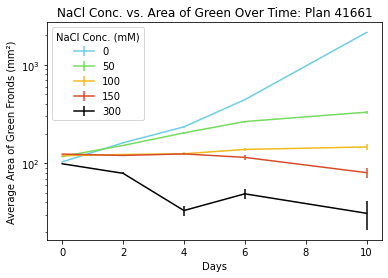

In [62]:
from cycler import cycler
import cycler
import matplotlib as mpl

colors = ["#6dcde3", "#75db5e", "#f2ba1f", "#d64d2b", "#000000"]
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', colors)
fig, ax = plt.subplots()
for conc in list(cond_dict.keys()):
    x = np.array(list(cond_dict[conc].keys()))
    y = np.array(list(cond_dict[conc].values()))
    plt.yscale('log')
    err = list(err_dict[cond])
    ax.errorbar(x, y, err, label = conc)
  
plt.legend(title="NaCl Conc. (mM)")
plt.title("NaCl Conc. vs. Area of Green Over Time: Plan %d" % plan.id)
plt.ylabel("Average Area of Green Fronds ({}\u00b2)".format("mm"))
plt.xlabel("Days")
plt.show()

# Now we analyze the frond dissenctions

In [70]:
"""
Resizing the images so finding the petri dish with Hough Circles won't take forever
"""
#making a new a directory for the resized images
dir_path_resized= "%s/Images_%d_CLUSTERS_CROPPED" % (cwd, plan_id)

try:
    os.mkdir(dir_path_resized)
except:
    for f in os.listdir(dir_path_resized):
        os.remove(os.path.join(dir_path_resized, f))
    print("Directory already exists. All files removed and replaced.")

#for each file, resize and save in new directory
for filename in os.listdir(dir_path_clusters):
    im_dir = dir_path_clusters + "/" + filename
    im = Image.open(im_dir)
    w, h = im.size
    #Resize image and save
    im = im.crop((0, 1000, w, 3300)) #cropping out the top and bottom of the image, which don't have the fronds
    h, w = im.size
    im = im.resize((int(h/5), int(w/5)), Image.ANTIALIAS)
    im.save(dir_path_resized + "/" + filename)


Directory already exists. All files removed and replaced.


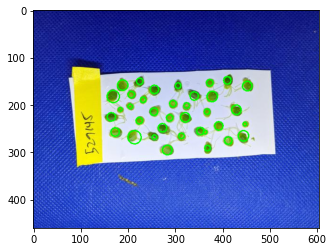

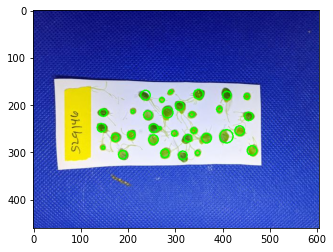

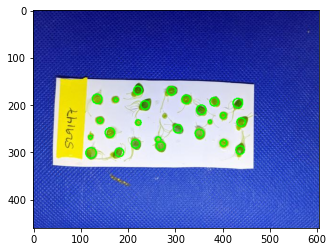

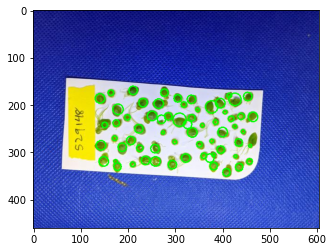

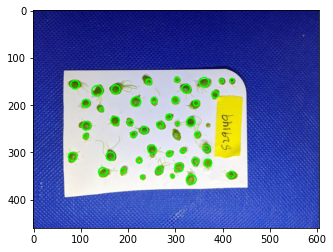

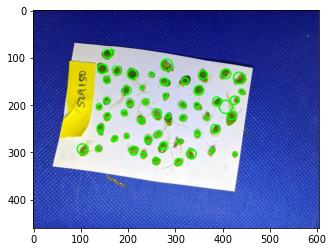

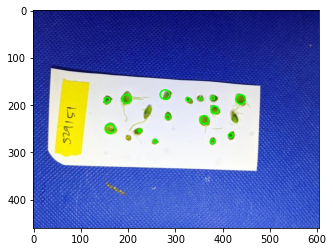

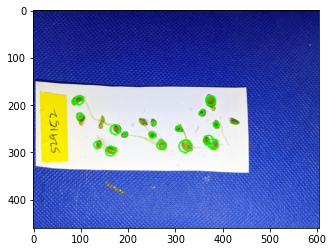

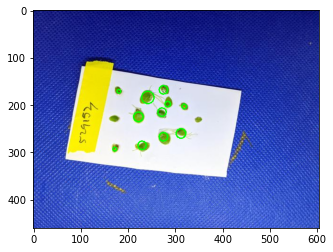

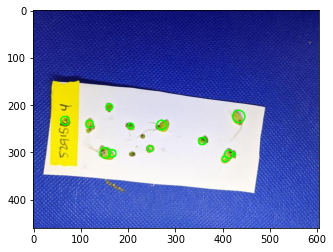

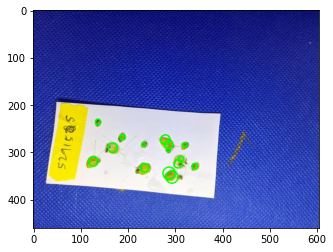

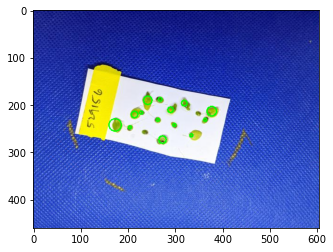

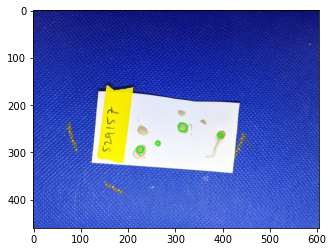

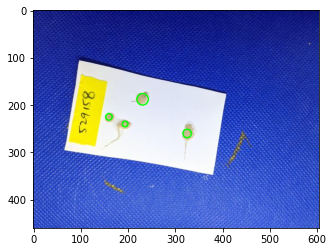

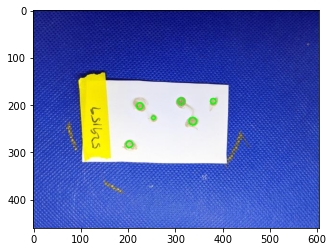

In [74]:
item_frond_diams = {} #keys are item, then a list of all diameters
for file in os.listdir(dir_path_resized):
    im = cv2.imread(os.path.join(dir_path_resized, file))
    im_orig = im.copy()
    fig = plt.figure()
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    for x in range(im.shape[0]):
        for y in range(im.shape[1]):
            if (im[x][y][0] > 110 and im[x][y][2] < 120 and im[x][y][1]<150) or (im[x][y][0] < 80 and im[x][y][1] > 200 and im[x][y][2]>200) or (im[x][y][0] >180 and im[x][y][1] > 180 and im[x][y][2] >180): #getting rid of all the blue 
                im[x][y] = [0, 0, 0]
    grey = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    grey = cv2.GaussianBlur(grey,(1, 1),0)
    kernel = np.ones((3, 3))
    grey = cv2.erode(grey, kernel, iterations = 2)
    trash, grey = cv2.threshold(grey, 50, 255, cv2.THRESH_BINARY)
    circles = cv2.HoughCircles(grey,cv2.HOUGH_GRADIENT,.2, minDist = 10, param1=200, param2=7, minRadius = 3, maxRadius=15)
    for i in circles[0,:]:
    # draw the outer circle
        i = [int(n) for n in i]
        cv2.circle(im_orig,(i[0],i[1]),i[2],(0,255, 0),2)
    plt.imshow(cv2.cvtColor(im_orig, cv2.COLOR_BGR2RGB))
    
    diams = list(circles[0, :, 2]) #getting the values for the diameters of each found circle
    item = id_from_filename(file)
    item_frond_diams[item] = diams

In [75]:
item_frond_diams

{'529145': [7.3,
  8.2,
  7.3,
  14.4,
  11.8,
  10.2,
  8.0,
  11.0,
  10.2,
  9.6,
  7.3,
  6.9,
  7.1,
  11.1,
  10.6,
  8.8,
  7.1,
  13.2,
  10.3,
  6.6,
  6.0,
  6.0,
  9.6,
  9.6,
  5.9,
  9.6,
  5.5,
  9.1,
  6.0,
  4.6,
  9.6,
  7.0,
  6.2,
  4.6,
  4.2,
  8.0],
 '529146': [9.6,
  9.1,
  10.3,
  9.6,
  6.9,
  14.4,
  10.8,
  10.3,
  8.2,
  10.3,
  9.1,
  6.0,
  10.3,
  9.1,
  6.0,
  11.8,
  9.6,
  9.6,
  9.1,
  8.4,
  8.4,
  8.2,
  9.6,
  5.0,
  5.5,
  10.0,
  6.5,
  4.2,
  5.2,
  3.35,
  3.35,
  3.8],
 '529147': [9.4,
  10.3,
  9.4,
  9.6,
  7.4,
  9.6,
  9.4,
  11.1,
  10.6,
  10.2,
  9.6,
  9.6,
  9.4,
  6.6,
  6.9,
  9.6,
  9.6,
  9.4,
  9.4,
  3.35,
  10.3,
  6.0,
  6.2,
  4.0,
  4.6],
 '529148': [8.2,
  10.6,
  13.1,
  9.6,
  13.1,
  10.5,
  6.6,
  10.2,
  9.6,
  9.6,
  9.6,
  8.4,
  8.2,
  7.4,
  10.3,
  9.4,
  6.0,
  6.0,
  14.4,
  10.3,
  9.6,
  8.2,
  5.2,
  4.2,
  10.5,
  8.7,
  7.3,
  5.5,
  11.8,
  10.2,
  8.2,
  6.9,
  5.5,
  9.6,
  8.2,
  10.6,
  4.2,
  9.3,
  9